Here is a formal summary report of the work conducted today. This document tracks the evolution from a simple game concept to a complex neuromorphic engineering challenge, highlighting the specific technical hurdles encountered in the `snntorch` implementation.

---

# Project Report: End-to-End Spiking Neural Network for Bat Echolocation

**Date:** November 24, 2025
**Frameworks:** Python, PyTorch, snntorch, Pygame
**Objective:** To develop a "closed-loop" Spiking Neural Network (SNN) that models both the generation of an echolocation pulse (Transmitter) and the decoding of the returning echo (Receiver) to estimate distance.

---

## 1. Project Evolution

The project began as an exploration of logic-based Python games (Minesweeper/Snake) but rapidly pivoted to scientific simulation.

1.  **Initial Concept:** Simulating basic bat echolocation using Raycasting in a 2D Pygame environment.
2.  **Biological Upgrade:** Moving from "perfect" distance sensors to **Latency Coding**, where distance is represented by the *time delay* of a spike.
3.  **Literature Alignment:** Based on a review of current computational models (Tandon, Hoshino, Bat-G Net), we identified a **"Literature Gap"**:
    * *Existing models* focus only on the Receiver (Ear/Brain).
    * *Our novelty* is modeling the Transmitter (Vocal-Motor System) using SNNs to create a stochastic, closed-loop system.
4.  **Final Architecture:** A "Jeffress Coincidence Detector" model implemented in `snntorch`, designed to learn a Topological Map (Place Coding) of distance.

---

## 2. Technical Architecture Implemented

We moved away from hard-coded logic to a Trainable SNN pipeline:

* **Input Data:** 2-Channel Spike Train.
    * Channel 0: The "Motor Copy" (Pulse emitted at $t=0$).
    * Channel 1: The "Echo" (Returning spike at $t=delay$).
* **Hidden Layer:** Leaky Integrate-and-Fire (LIF) neurons acting as "Delay Lines."
* **Output Layer:** 100 Neurons representing a "Place Map."
    * Neuron 5 spiking $\rightarrow$ Target is at distance 5.
    * Neuron 80 spiking $\rightarrow$ Target is at distance 80.
* **Learning Mechanism:** Surrogate Gradients (`fast_sigmoid`) allowing Backpropagation through time.

---

## 3. Challenges & Solutions Log

This section details the specific failures encountered during the training phase and the engineering solutions applied.

### Challenge A: The "Mean Prediction" Failure
**Symptom:** The model converged to a state where it constantly predicted the average distance (MAE $\approx$ 25 on a 0-50 scale), regardless of the input.
**Root Cause:** The network was treating the batch as a static image rather than a time-series, or failing to reset memory between samples.
**Solution Implemented:**
* **Time-First Permutation:** Enforced `[Time, Batch, Features]` dimension ordering using `x.permute(1, 0, 2)`.
* **State Reset:** Implemented `utils.reset(net)` inside the training loop to prevent "voltage bleed" from one sample to the next.

### Challenge B: The "Dead Neuron" / Initialization Issue
**Symptom:** During early training, the hidden layer showed flat membrane potentials. The "Echo" spike was insufficient to push the voltage over the threshold.
**Solution Implemented:**
* **Weight Boosting:** Manually scaled the initialization weights of `nn.Linear` layers by a factor of 2.0x to 5.0x to ensure the sparse input spikes caused a reaction.
* **Diagnostic Visualization:** Added a "Probe Cell" to plot $V_{mem}$ traces of single samples, confirming that voltage was now moving in response to inputs.

### Challenge C: The "Signal Decay" (Vanishing Spike Problem)
**Symptom:** Even with the code fixed, the model struggled to detect "Far" objects (long delays).
**Root Cause:** The Physics of the Leaky Neuron.
* With a standard decay rate ($\beta=0.9$), the voltage from the initial pulse ($t=0$) decays to near-zero ($0.9^{50} \approx 0.005$) by the time the echo arrives ($t=50$).
* Coincidence detection became mathematically impossible because the "memory" of the pulse had vanished.
**Current Solution (In Progress):**
1.  **High-Beta Initialization:** Increasing $\beta$ to **0.99** so that voltage persists for >100 time steps.
2.  **Learnable Beta:** Setting `learn_beta=True` in `snntorch`, allowing the network to *learn* its own memory duration.

### Challenge D: Loss Function Rigidity
**Symptom:** `CrossEntropyLoss` was punishing "Near Misses" (predicting 40 when the answer is 41) too harshly, making convergence difficult.
**Current Solution (In Progress):**
* **Gaussian Smoothing:** Replacing One-Hot targets with a Gaussian distribution. This turns the discrete classification task into a "Soft Regression," guiding the gradient towards the correct neighborhood.

---

## 4. Next Steps

To finalize the project and achieve a functional "Bat Brain," the following roadmap is established:

1.  **Run the "High-Beta" Training:** Validate that $\beta=0.99$ solves the signal decay issue.
2.  **Continuous Decoding:** Implement the weighted average decoder to turn the 100 output neurons into a floating-point distance estimate.
3.  **Visualization:** Generate the "Diagonal Raster Plot" — the "Holy Grail" visual that proves the network has learned a topological map of space.
4.  **Doppler Integration:** (Future) Introduce frequency modulation to the inputs to allow the SNN to detect velocity as well as range.

--- STANDARD SIMULATION (Slides 7-8) ---
Params: Beta=0.9, w1=0.7, w2=0.6, Threshold=1.0

Delay d=1: V = 0.9^1 * 0.7 + 0.6 = 1.2300 -> Spike
Delay d=10: V = 0.9^10 * 0.7 + 0.6 = 0.8441 -> No Spike


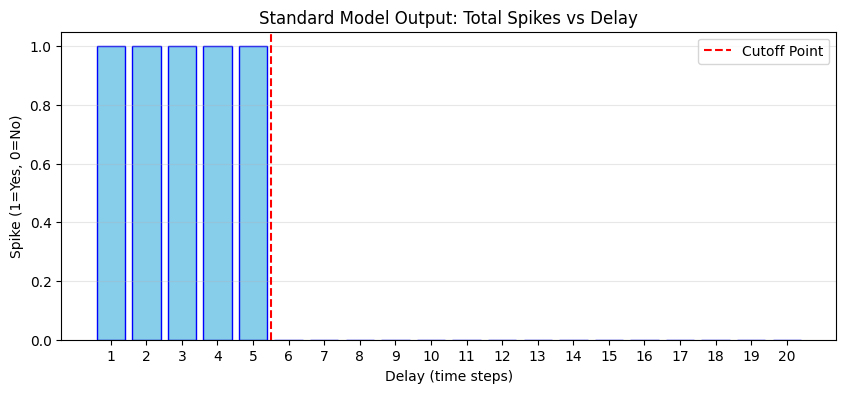


--- INHIBITORY SIMULATION (Slide 9 Fix) ---
Inhibitory Params: w_inh=0.8, beta_inh=0.5 (Fast Decay)
Delay 1: V_exc (1.23) - V_inh (0.40) = 0.83 -> SILENCE (Fixed)
Delay 5: V_exc (1.01) - V_inh (0.03) = 0.99 -> No Spike


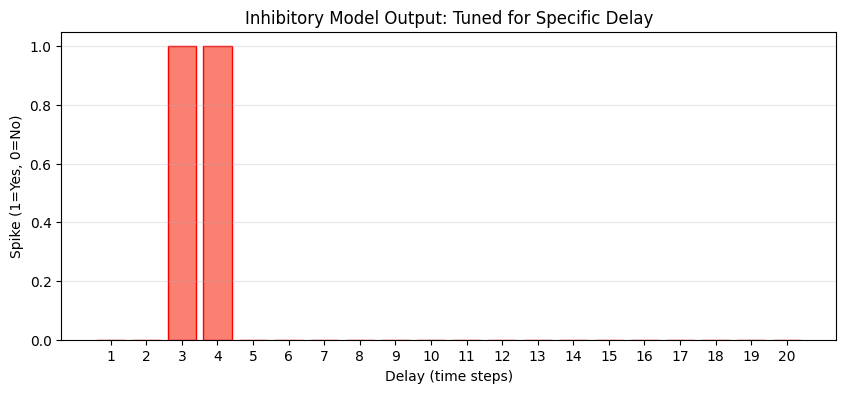

In [2]:
import torch
import matplotlib.pyplot as plt

def run_standard_simulation():
    """
    Recreates the calculations from Slide 7 and 8.
    Demonstrates why the standard LIF acts as a 'short-delay detector'.
    """
    print("--- STANDARD SIMULATION (Slides 7-8) ---")
    
    # Parameters from PDF
    beta = 0.9
    w1 = 0.7  # Weight for Pulse (FM1)
    w2 = 0.6  # Weight for Echo (FM3)
    threshold = 1.0
    
    # Simulation settings
    delays_to_test = range(1, 21) # Test delays 1 to 20
    spikes_recorded = []
    
    print(f"Params: Beta={beta}, w1={w1}, w2={w2}, Threshold={threshold}\n")
    
    for d in delays_to_test:
        # Calculate Voltage at moment of Echo explicitly using the formula from Slide 7
        # V_te = (beta^d * w1) + w2
        v_at_echo = (pow(beta, d) * w1) + w2
        
        # Check spike
        did_spike = v_at_echo > threshold
        spikes_recorded.append(1.0 if did_spike else 0.0)
        
        # Print specific example from Slide 8
        if d == 1:
            print(f"Delay d={d}: V = {beta}^{d} * {w1} + {w2} = {v_at_echo:.4f} -> {'Spike' if did_spike else 'No Spike'}")
        if d == 10:
             print(f"Delay d={d}: V = {beta}^{d} * {w1} + {w2} = {v_at_echo:.4f} -> {'Spike' if did_spike else 'No Spike'}")

    # Visualization
    plt.figure(figsize=(10, 4))
    plt.bar(delays_to_test, spikes_recorded, color='skyblue', edgecolor='blue')
    plt.title("Standard Model Output: Total Spikes vs Delay")
    plt.xlabel("Delay (time steps)")
    plt.ylabel("Spike (1=Yes, 0=No)")
    plt.xticks(delays_to_test)
    plt.axvline(x=5.5, color='r', linestyle='--', label='Cutoff Point')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

def run_inhibitory_simulation():
    """
    Implements the solution from Slide 9.
    Adds a rapidly decaying inhibitory current triggered by the Pulse.
    """
    print("\n--- INHIBITORY SIMULATION (Slide 9 Fix) ---")
    
    # Standard Params
    beta = 0.9
    w1 = 0.7 
    w2 = 0.6
    threshold = 1.0
    
    # Inhibitory Params (Manual Tuning as suggested in Slide 9)
    w_inh = 0.8      # Strength of inhibition
    beta_inh = 0.5   # Decays RAPIDLY (faster than the membrane beta)
    
    delays_to_test = range(1, 21)
    spikes_recorded = []
    
    print(f"Inhibitory Params: w_inh={w_inh}, beta_inh={beta_inh} (Fast Decay)")
    
    for d in delays_to_test:
        # 1. Calculate Excitatory Voltage at Echo (Standard Trace)
        v_exc = (pow(beta, d) * w1) + w2
        
        # 2. Calculate Inhibitory Voltage at Echo
        # Inhibition starts at Pulse and decays over 'd' steps
        v_inh = pow(beta_inh, d) * w_inh
        
        # 3. Net Voltage
        v_net = v_exc - v_inh
        
        did_spike = v_net > threshold
        spikes_recorded.append(1.0 if did_spike else 0.0)
        
        # Print logic for short delay vs target delay
        if d == 1:
             print(f"Delay {d}: V_exc ({v_exc:.2f}) - V_inh ({v_inh:.2f}) = {v_net:.2f} -> {'Spike' if did_spike else 'SILENCE (Fixed)'}")
        if d == 5:
             print(f"Delay {d}: V_exc ({v_exc:.2f}) - V_inh ({v_inh:.2f}) = {v_net:.2f} -> {'Spike' if did_spike else 'No Spike'}")

    # Visualization
    plt.figure(figsize=(10, 4))
    plt.bar(delays_to_test, spikes_recorded, color='salmon', edgecolor='red')
    plt.title("Inhibitory Model Output: Tuned for Specific Delay")
    plt.xlabel("Delay (time steps)")
    plt.ylabel("Spike (1=Yes, 0=No)")
    plt.xticks(delays_to_test)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

if __name__ == "__main__":
    # 1. Run the problem case
    run_standard_simulation()
    
    # 2. Run the solution case
    run_inhibitory_simulation()